# Inspiration
- https://medium.com/stanford-cs224w/lightgcn-with-pytorch-geometric-91bab836471e

In [1]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from torch import torch
from sklearn import preprocessing

from torch_geometric.data import Data
from torch_geometric.transforms.to_undirected import ToUndirected

In [2]:
torch.__version__

'2.1.1+cu118'

In [3]:

import random
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim, Tensor

from torch_sparse import SparseTensor, matmul

from torch_geometric.utils import structured_negative_sampling
from torch_geometric.data import download_url, extract_zip
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.typing import Adj

In [4]:
postings_1 = pd.read_csv("../data/Postings_01052019_15052019.csv", sep = ';')
postings_2 = pd.read_csv("../data/Postings_16052019_31052019.csv", sep = ';')
votes_1 = pd.read_csv("../data/Votes_01052019_15052019.csv", sep = ';')
votes_2 = pd.read_csv("../data/Votes_16052019_31052019.csv", sep = ';')
postings = pd.concat([postings_1, postings_2])
votes = pd.concat([votes_1, votes_2])

In [5]:
post_article = postings.groupby(by = ['ID_CommunityIdentity', 'ID_Article']).agg({"ArticlePublishingDate": "min"})
post_article = post_article.reset_index()
votes_trunc = votes[['ID_CommunityIdentity', 'ID_Posting']]
postings_trunc = postings.groupby(by = ['ID_Posting', 'ID_Article']).agg({"ArticlePublishingDate": "min"}).reset_index().drop(columns = ['ArticlePublishingDate'])
vote_user_article = votes_trunc.merge(postings_trunc, left_on = ['ID_Posting'], right_on = ['ID_Posting'])
vote_article = vote_user_article.groupby(by = ['ID_CommunityIdentity', 'ID_Article']).agg({"ID_Posting": "count"}).reset_index().drop(columns = ['ID_Posting'])
user_article_interaction = pd.concat([post_article, vote_article]).drop(columns=['ArticlePublishingDate'])

In [6]:
# create edge names
user_article_interaction["user_id"] = "u-" + user_article_interaction["ID_CommunityIdentity"].astype(str)
user_article_interaction["article_id"] = "a-" + user_article_interaction["ID_Article"].astype(str)

# concatenate nodes and create node encodings
nodes = np.concatenate((np.unique(user_article_interaction['user_id']), np.unique(user_article_interaction['article_id'])))
nodes_user = np.unique(user_article_interaction['user_id'])
nodes_article = np.unique(user_article_interaction['article_id'])

label_encoder_nodes = preprocessing.LabelEncoder()
label_encoder_nodes.fit(nodes)
nodes_enc = label_encoder_nodes.transform(nodes)

user_article_interaction["user_id_enc"] = label_encoder_nodes.transform(user_article_interaction["user_id"])
user_article_interaction["article_enc"] = label_encoder_nodes.transform(user_article_interaction["article_id"])

In [7]:
users_mapping = {index: i for i, index in enumerate(np.unique(user_article_interaction['user_id']))}
articles_mapping = {index: i for i, index in enumerate(np.unique(user_article_interaction['article_id']))}

user_article_interaction["user_id_enc_map"] = user_article_interaction["user_id"].map(users_mapping)
user_article_interaction["article_enc_map"] = user_article_interaction["article_id"].map(articles_mapping)

In [8]:
edge_index = torch.stack([torch.tensor(np.array(user_article_interaction["user_id_enc_map"])), torch.tensor(np.array(user_article_interaction["article_enc_map"]))])

In [37]:
# split the edges of the graph using a 80/10/10 train/validation/test split
num_users, num_articles= len(np.unique(user_article_interaction["user_id_enc"])), len(np.unique(user_article_interaction["article_enc"]))
num_interactions = edge_index.shape[1]
all_indices = [i for i in range(num_interactions)]

train_indices, test_indices = train_test_split(
    all_indices, test_size=0.2, random_state=1)
val_indices, test_indices = train_test_split(
    test_indices, test_size=0.5, random_state=1)

train_edge_index = edge_index[:, train_indices]
val_edge_index = edge_index[:, val_indices]
test_edge_index = edge_index[:, test_indices]

print("Train edge index shape: ", train_edge_index.shape)
print("Val edge index shape: ", val_edge_index.shape)
print("Test edge index shape: ", test_edge_index.shape)

train_edge_index = train_edge_index.to(torch.long)
val_edge_index = val_edge_index.to(torch.long)
test_edge_index = test_edge_index.to(torch.long)


Train edge index shape:  torch.Size([2, 873545])
Val edge index shape:  torch.Size([2, 109193])
Test edge index shape:  torch.Size([2, 109194])


In [38]:
train_edge_index.shape

torch.Size([2, 873545])

In [39]:
label_encoder_nodes.inverse_transform([train_edge_index[1][1000].item()])

array(['a-2000102654283'], dtype=object)

In [40]:
train_sparse_edge_index = SparseTensor(row=train_edge_index[0], col=train_edge_index[1], sparse_sizes=(
    num_users + num_articles, num_users + num_articles))
val_sparse_edge_index = SparseTensor(row=val_edge_index[0], col=val_edge_index[1], sparse_sizes=(
    num_users + num_articles, num_users + num_articles))
test_sparse_edge_index = SparseTensor(row=test_edge_index[0], col=test_edge_index[1], sparse_sizes=(
    num_users + num_articles, num_users + num_articles))

In [41]:
train_sparse_edge_index

SparseTensor(row=tensor([    0,     0,     0,  ..., 33702, 33702, 33702], device='cuda:0'),
             col=tensor([  91,   94,   99,  ..., 3474, 3907, 4100], device='cuda:0'),
             size=(38054, 38054), nnz=873545, density=0.06%)

In [42]:
# defines LightGCN model
class LightGCN(MessagePassing):
    """LightGCN Model as proposed in https://arxiv.org/abs/2002.02126
    """

    def __init__(self, num_users, num_items, embedding_dim=64, K=3, add_self_loops=False):
        """Initializes LightGCN Model

        Args:
            num_users (int): Number of users
            num_items (int): Number of items
            embedding_dim (int, optional): Dimensionality of embeddings. Defaults to 8.
            K (int, optional): Number of message passing layers. Defaults to 3.
            add_self_loops (bool, optional): Whether to add self loops for message passing. Defaults to False.
        """
        super().__init__()
        self.num_users, self.num_items = num_users, num_items
        self.embedding_dim, self.K = embedding_dim, K
        self.add_self_loops = add_self_loops

        self.users_emb = nn.Embedding(
            num_embeddings=self.num_users, embedding_dim=self.embedding_dim) # e_u^0
        self.items_emb = nn.Embedding(
            num_embeddings=self.num_items, embedding_dim=self.embedding_dim) # e_i^0

        nn.init.normal_(self.users_emb.weight, std=0.1)
        nn.init.normal_(self.items_emb.weight, std=0.1)

    def forward(self, edge_index: SparseTensor):
        """Forward propagation of LightGCN Model.

        Args:
            edge_index (SparseTensor): adjacency matrix

        Returns:
            tuple (Tensor): e_u_k, e_u_0, e_i_k, e_i_0
        """
        # compute \tilde{A}: symmetrically normalized adjacency matrix
        edge_index_norm = gcn_norm(
            edge_index, add_self_loops=self.add_self_loops)

        emb_0 = torch.cat([self.users_emb.weight, self.items_emb.weight]) # E^0
        embs = [emb_0]
        emb_k = emb_0

        # multi-scale diffusion
        for i in range(self.K):
            emb_k = self.propagate(edge_index_norm, x=emb_k)
            embs.append(emb_k)

        embs = torch.stack(embs, dim=1)
        emb_final = torch.mean(embs, dim=1) # E^K

        users_emb_final, items_emb_final = torch.split(
            emb_final, [self.num_users, self.num_items]) # splits into e_u^K and e_i^K

        # returns e_u^K, e_u^0, e_i^K, e_i^0
        return users_emb_final, self.users_emb.weight, items_emb_final, self.items_emb.weight

    def message(self, x_j: Tensor) -> Tensor:
        return x_j

    def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
        # computes \tilde{A} @ x
        return matmul(adj_t, x)

model = LightGCN(num_users, num_articles)

In [44]:
def bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0, neg_items_emb_final, neg_items_emb_0, lambda_val):
    """Bayesian Personalized Ranking Loss as described in https://arxiv.org/abs/1205.2618

    Args:
        users_emb_final (torch.Tensor): e_u_k
        users_emb_0 (torch.Tensor): e_u_0
        pos_items_emb_final (torch.Tensor): positive e_i_k
        pos_items_emb_0 (torch.Tensor): positive e_i_0
        neg_items_emb_final (torch.Tensor): negative e_i_k
        neg_items_emb_0 (torch.Tensor): negative e_i_0
        lambda_val (float): lambda value for regularization loss term

    Returns:
        torch.Tensor: scalar bpr loss value
    """
    reg_loss = lambda_val * (users_emb_0.norm(2).pow(2) +
                             pos_items_emb_0.norm(2).pow(2) +
                             neg_items_emb_0.norm(2).pow(2)) # L2 loss

    pos_scores = torch.mul(users_emb_final, pos_items_emb_final)
    pos_scores = torch.sum(pos_scores, dim=-1) # predicted scores of positive samples
    neg_scores = torch.mul(users_emb_final, neg_items_emb_final)
    neg_scores = torch.sum(neg_scores, dim=-1) # predicted scores of negative samples

    loss = -torch.mean(torch.nn.functional.softplus(pos_scores - neg_scores)) + reg_loss

    return loss

In [45]:
# helper function to get N_u
def get_user_positive_items(edge_index):
    """Generates dictionary of positive items for each user

    Args:
        edge_index (torch.Tensor): 2 by N list of edges

    Returns:
        dict: dictionary of positive items for each user
    """
    user_pos_items = {}
    for i in range(edge_index.shape[1]):
        user = edge_index[0][i].item()
        item = edge_index[1][i].item()
        if user not in user_pos_items:
            user_pos_items[user] = []
        user_pos_items[user].append(item)
    return user_pos_items

In [46]:
# computes recall@K and precision@K
def RecallPrecision_ATk(groundTruth, r, k):
    """Computers recall @ k and precision @ k

    Args:
        groundTruth (list): list of lists containing highly rated items of each user
        r (list): list of lists indicating whether each top k item recommended to each user
            is a top k ground truth item or not
        k (intg): determines the top k items to compute precision and recall on

    Returns:
        tuple: recall @ k, precision @ k
    """
    num_correct_pred = torch.sum(r, dim=-1)  # number of correctly predicted items per user
    # number of items liked by each user in the test set
    user_num_liked = torch.Tensor([len(groundTruth[i])
                                  for i in range(len(groundTruth))])
    recall = torch.mean(num_correct_pred / user_num_liked)
    precision = torch.mean(num_correct_pred) / k
    return recall.item(), precision.item()

In [47]:
# computes NDCG@K
def NDCGatK_r(groundTruth, r, k):
    """Computes Normalized Discounted Cumulative Gain (NDCG) @ k

    Args:
        groundTruth (list): list of lists containing highly rated items of each user
        r (list): list of lists indicating whether each top k item recommended to each user
            is a top k ground truth item or not
        k (int): determines the top k items to compute ndcg on

    Returns:
        float: ndcg @ k
    """
    assert len(r) == len(groundTruth)

    test_matrix = torch.zeros((len(r), k))

    for i, items in enumerate(groundTruth):
        length = min(len(items), k)
        test_matrix[i, :length] = 1
    max_r = test_matrix
    idcg = torch.sum(max_r * 1. / torch.log2(torch.arange(2, k + 2)), axis=1)
    dcg = r * (1. / torch.log2(torch.arange(2, k + 2)))
    dcg = torch.sum(dcg, axis=1)
    idcg[idcg == 0.] = 1.
    ndcg = dcg / idcg
    ndcg[torch.isnan(ndcg)] = 0.
    return torch.mean(ndcg).item()

In [48]:
# wrapper function to get evaluation metrics
def get_metrics(model, edge_index, exclude_edge_indices, k):
    """Computes the evaluation metrics: recall, precision, and ndcg @ k

    Args:
        model (LighGCN): lightgcn model
        edge_index (torch.Tensor): 2 by N list of edges for split to evaluate
        exclude_edge_indices ([type]): 2 by N list of edges for split to discount from evaluation
        k (int): determines the top k items to compute metrics on

    Returns:
        tuple: recall @ k, precision @ k, ndcg @ k
    """
    user_embedding = model.users_emb.weight
    item_embedding = model.items_emb.weight

    # get ratings between every user and item - shape is num users x num movies
    rating = torch.matmul(user_embedding, item_embedding.T)

    for exclude_edge_index in exclude_edge_indices:
        # gets all the positive items for each user from the edge index
        user_pos_items = get_user_positive_items(exclude_edge_index)
        # get coordinates of all edges to exclude
        exclude_users = []
        exclude_items = []
        for user, items in user_pos_items.items():
            exclude_users.extend([user] * len(items))
            exclude_items.extend(items)

        # set ratings of excluded edges to large negative value
        rating[exclude_users, exclude_items] = -(1 << 10)

    # get the top k recommended items for each user
    _, top_K_items = torch.topk(rating, k=k)

    # get all unique users in evaluated split
    users = edge_index[0].unique()

    test_user_pos_items = get_user_positive_items(edge_index)

    # convert test user pos items dictionary into a list
    test_user_pos_items_list = [
        test_user_pos_items[user.item()] for user in users]

    # determine the correctness of topk predictions
    r = []
    for user in users:
        ground_truth_items = test_user_pos_items[user.item()]
        label = list(map(lambda x: x in ground_truth_items, top_K_items[user]))
        r.append(label)
    r = torch.Tensor(np.array(r).astype('float'))

    recall, precision = RecallPrecision_ATk(test_user_pos_items_list, r, k)
    ndcg = NDCGatK_r(test_user_pos_items_list, r, k)

    return recall, precision, ndcg

In [49]:
# wrapper function to evaluate model
def evaluation(model, edge_index, sparse_edge_index, exclude_edge_indices, k, lambda_val):
    """Evaluates model loss and metrics including recall, precision, ndcg @ k

    Args:
        model (LighGCN): lightgcn model
        edge_index (torch.Tensor): 2 by N list of edges for split to evaluate
        sparse_edge_index (sparseTensor): sparse adjacency matrix for split to evaluate
        exclude_edge_indices ([type]): 2 by N list of edges for split to discount from evaluation
        k (int): determines the top k items to compute metrics on
        lambda_val (float): determines lambda for bpr loss

    Returns:
        tuple: bpr loss, recall @ k, precision @ k, ndcg @ k
    """
    # get embeddings
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(sparse_edge_index)
    edges = structured_negative_sampling(edge_index, contains_neg_self_loops=False)
    user_indices, pos_item_indices, neg_item_indices = edges[0], edges[1], edges[2]
    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[
        pos_item_indices], items_emb_0[pos_item_indices]
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[
        neg_item_indices], items_emb_0[neg_item_indices]

    loss = bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0,
                    neg_items_emb_final, neg_items_emb_0, lambda_val).item()

    recall, precision, ndcg = get_metrics(
        model, edge_index, exclude_edge_indices, k)

    return loss, recall, precision, ndcg

In [50]:
# define contants
ITERATIONS = 10000
BATCH_SIZE = 512
LR = 1e-3
ITERS_PER_EVAL = 200
ITERS_PER_LR_DECAY = 200
K = 20
LAMBDA = 1e-6

In [51]:
# setup
device_name = 'cuda' if torch.cuda.is_available() else 'cpu'
# device_name = 'cpu'
device = torch.device(device_name)
print(f"Using device {device}.")


model = model.to(device)
model.train()

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
train_sparse_edge_index = train_sparse_edge_index.to(device)

val_edge_index = val_edge_index.to(device)
val_sparse_edge_index = val_sparse_edge_index.to(device)

Using device cuda.


In [52]:
train_edge_index.shape

torch.Size([2, 873545])

In [53]:
from torch_geometric.utils.negative_sampling import structured_negative_sampling_feasible

In [63]:
import random
from typing import Optional, Tuple, Union

import numpy as np
import torch
from torch import Tensor

from torch_geometric.utils import coalesce, cumsum, degree, remove_self_loops
from torch_geometric.utils.num_nodes import maybe_num_nodes

def structured_negative_sampling(edge_index, num_nodes: Optional[int] = None,
                                 contains_neg_self_loops: bool = True):
    
    num_nodes = maybe_num_nodes(edge_index, num_nodes)

    row, col = edge_index.cpu()

    pos_idx = row * num_nodes + col
    if not contains_neg_self_loops:
        loop_idx = torch.arange(num_nodes) * (num_nodes + 1)
        pos_idx = torch.cat([pos_idx, loop_idx], dim=0)

    # Get the unique nodes from the columns of edge_index
    unique_nodes = torch.unique(edge_index[1]).cpu()

    # Generate random indices for negative edges from unique_nodes
    rand = torch.randint(len(unique_nodes), (row.size(0), ), dtype=torch.long)
    neg_idx = row * num_nodes + unique_nodes[rand]

    mask = torch.from_numpy(np.isin(neg_idx, pos_idx)).to(torch.bool)
    rest = mask.nonzero(as_tuple=False).view(-1)

    while rest.numel() > 0:  # pragma: no cover
        tmp = torch.randint(len(unique_nodes), (rest.size(0), ), dtype=torch.long)
        rand[rest] = tmp
        neg_idx = row[rest] * num_nodes + unique_nodes[tmp]

        mask = torch.from_numpy(np.isin(neg_idx, pos_idx)).to(torch.bool)
        rest = rest[mask]

    return edge_index[0], edge_index[1], unique_nodes[rand].to(edge_index.device)

In [64]:
# function which random samples a mini-batch of positive and negative samples
def sample_mini_batch(batch_size, edge_index):
    """Randomly samples indices of a minibatch given an adjacency matrix

    Args:
        batch_size (int): minibatch size
        edge_index (torch.Tensor): 2 by N list of edges

    Returns:
        tuple: user indices, positive item indices, negative item indices
    """
    sampled_edges = structured_negative_sampling(edge_index, contains_neg_self_loops=False)
    sampled_edges = torch.stack(sampled_edges, dim=0)
    
    indices = random.choices(
        [i for i in range(sampled_edges[0].shape[0])], k=batch_size)
    batch = sampled_edges[:, indices]
    user_indices, pos_item_indices, neg_item_indices = batch[0], batch[1], batch[2]
    return user_indices, pos_item_indices, neg_item_indices

In [72]:
# training loop
train_losses = []
val_losses = []

for iter in tqdm(range(ITERATIONS)):

    # forward propagation
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(train_sparse_edge_index)

    # mini batching
    user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(BATCH_SIZE, train_edge_index)
    user_indices, pos_item_indices, neg_item_indices = user_indices.to(device), pos_item_indices.to(device), neg_item_indices.to(device)
    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[pos_item_indices], items_emb_0[pos_item_indices]
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[neg_item_indices], items_emb_0[neg_item_indices]

    # loss computation
    train_loss = bpr_loss(users_emb_final, users_emb_0, pos_items_emb_final,
                          pos_items_emb_0, neg_items_emb_final, neg_items_emb_0, LAMBDA)

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    if iter % ITERS_PER_EVAL == 0:
        model.eval()
        val_loss, recall, precision, ndcg = evaluation(
            model, val_edge_index, val_sparse_edge_index, [train_edge_index], K, LAMBDA)
        print(f"[Iteration {iter}/{ITERATIONS}] train_loss: {round(train_loss.item(), 5)}, val_loss: {round(val_loss, 5)}, val_recall@{K}: {round(recall, 5)}, val_precision@{K}: {round(precision, 5)}, val_ndcg@{K}: {round(ndcg, 5)}")
        train_losses.append(train_loss.item())
        val_losses.append(val_loss)
        model.train()

    if iter % ITERS_PER_LR_DECAY == 0 and iter != 0:
        scheduler.step()

  0%|          | 1/10000 [01:05<180:52:03, 65.12s/it]

[Iteration 0/10000] train_loss: -1.01765, val_loss: -0.46454, val_recall@20: 0.01738, val_precision@20: 0.00447, val_ndcg@20: 0.01021


  2%|▏         | 201/10000 [03:07<52:48:17, 19.40s/it]

[Iteration 200/10000] train_loss: -6.94468, val_loss: -0.66169, val_recall@20: 0.04714, val_precision@20: 0.01321, val_ndcg@20: 0.02997


  4%|▍         | 401/10000 [05:08<51:01:42, 19.14s/it]

[Iteration 400/10000] train_loss: -15.03357, val_loss: -1.42486, val_recall@20: 0.05894, val_precision@20: 0.01507, val_ndcg@20: 0.03679


  6%|▌         | 601/10000 [07:11<50:09:54, 19.21s/it]

[Iteration 600/10000] train_loss: -26.32231, val_loss: -2.53158, val_recall@20: 0.06251, val_precision@20: 0.01562, val_ndcg@20: 0.03947


  8%|▊         | 801/10000 [09:18<50:24:26, 19.73s/it]

[Iteration 800/10000] train_loss: -43.65143, val_loss: -3.86278, val_recall@20: 0.06457, val_precision@20: 0.01593, val_ndcg@20: 0.04094


 10%|█         | 1001/10000 [11:16<46:58:12, 18.79s/it]

[Iteration 1000/10000] train_loss: -63.06721, val_loss: -5.31771, val_recall@20: 0.06592, val_precision@20: 0.01606, val_ndcg@20: 0.04176


 12%|█▏        | 1201/10000 [13:14<45:33:43, 18.64s/it]

[Iteration 1200/10000] train_loss: -68.72775, val_loss: -6.90973, val_recall@20: 0.0663, val_precision@20: 0.01608, val_ndcg@20: 0.0421


 14%|█▍        | 1401/10000 [15:11<43:59:39, 18.42s/it]

[Iteration 1400/10000] train_loss: -91.88173, val_loss: -8.45302, val_recall@20: 0.06754, val_precision@20: 0.01616, val_ndcg@20: 0.04245


 16%|█▌        | 1601/10000 [17:09<43:39:56, 18.72s/it]

[Iteration 1600/10000] train_loss: -101.64218, val_loss: -10.10027, val_recall@20: 0.068, val_precision@20: 0.01615, val_ndcg@20: 0.04265


 18%|█▊        | 1801/10000 [19:09<43:11:05, 18.96s/it]

[Iteration 1800/10000] train_loss: -125.11151, val_loss: -11.83055, val_recall@20: 0.06842, val_precision@20: 0.01619, val_ndcg@20: 0.04287


 20%|██        | 2001/10000 [21:17<46:53:19, 21.10s/it]

[Iteration 2000/10000] train_loss: -154.95152, val_loss: -13.44969, val_recall@20: 0.06864, val_precision@20: 0.01619, val_ndcg@20: 0.04294


 22%|██▏       | 2201/10000 [23:32<47:51:59, 22.10s/it]

[Iteration 2200/10000] train_loss: -165.21774, val_loss: -15.15266, val_recall@20: 0.06872, val_precision@20: 0.01616, val_ndcg@20: 0.04306


 24%|██▍       | 2401/10000 [25:42<41:55:17, 19.86s/it]

[Iteration 2400/10000] train_loss: -181.53651, val_loss: -16.78273, val_recall@20: 0.0695, val_precision@20: 0.01627, val_ndcg@20: 0.04328


 26%|██▌       | 2601/10000 [27:47<40:08:55, 19.53s/it]

[Iteration 2600/10000] train_loss: -210.50883, val_loss: -18.41566, val_recall@20: 0.06905, val_precision@20: 0.01624, val_ndcg@20: 0.04324


 28%|██▊       | 2801/10000 [29:48<38:58:35, 19.49s/it]

[Iteration 2800/10000] train_loss: -223.20828, val_loss: -19.92183, val_recall@20: 0.06878, val_precision@20: 0.01623, val_ndcg@20: 0.04322


 30%|███       | 3001/10000 [31:52<39:23:54, 20.26s/it]

[Iteration 3000/10000] train_loss: -214.94012, val_loss: -21.28662, val_recall@20: 0.06908, val_precision@20: 0.01628, val_ndcg@20: 0.04336


 32%|███▏      | 3201/10000 [33:57<38:12:58, 20.24s/it]

[Iteration 3200/10000] train_loss: -232.06415, val_loss: -22.951, val_recall@20: 0.06959, val_precision@20: 0.01632, val_ndcg@20: 0.04357


 34%|███▍      | 3401/10000 [36:06<38:25:56, 20.97s/it]

[Iteration 3400/10000] train_loss: -264.47296, val_loss: -24.34118, val_recall@20: 0.06953, val_precision@20: 0.0163, val_ndcg@20: 0.04353


 36%|███▌      | 3601/10000 [38:16<36:39:18, 20.62s/it]

[Iteration 3600/10000] train_loss: -269.9024, val_loss: -25.60968, val_recall@20: 0.06952, val_precision@20: 0.01631, val_ndcg@20: 0.04358


 38%|███▊      | 3801/10000 [40:38<40:20:23, 23.43s/it]

[Iteration 3800/10000] train_loss: -280.91928, val_loss: -26.93742, val_recall@20: 0.06954, val_precision@20: 0.01633, val_ndcg@20: 0.04359


 40%|████      | 4001/10000 [42:53<37:56:00, 22.76s/it]

[Iteration 4000/10000] train_loss: -301.58923, val_loss: -28.21677, val_recall@20: 0.06959, val_precision@20: 0.01631, val_ndcg@20: 0.04364


 42%|████▏     | 4201/10000 [44:59<32:04:30, 19.91s/it]

[Iteration 4200/10000] train_loss: -313.05896, val_loss: -29.50239, val_recall@20: 0.06941, val_precision@20: 0.01628, val_ndcg@20: 0.04362


 44%|████▍     | 4401/10000 [46:58<29:53:29, 19.22s/it]

[Iteration 4400/10000] train_loss: -319.20175, val_loss: -30.69048, val_recall@20: 0.06936, val_precision@20: 0.01626, val_ndcg@20: 0.04357


 46%|████▌     | 4601/10000 [49:00<29:11:20, 19.46s/it]

[Iteration 4600/10000] train_loss: -332.76572, val_loss: -31.80843, val_recall@20: 0.06955, val_precision@20: 0.01628, val_ndcg@20: 0.04363


 48%|████▊     | 4801/10000 [50:59<27:25:42, 18.99s/it]

[Iteration 4800/10000] train_loss: -348.1796, val_loss: -33.0366, val_recall@20: 0.06959, val_precision@20: 0.01628, val_ndcg@20: 0.04363


 50%|█████     | 5001/10000 [53:01<27:00:03, 19.44s/it]

[Iteration 5000/10000] train_loss: -337.38889, val_loss: -34.1117, val_recall@20: 0.06972, val_precision@20: 0.0163, val_ndcg@20: 0.04368


 52%|█████▏    | 5201/10000 [55:04<26:25:42, 19.83s/it]

[Iteration 5200/10000] train_loss: -390.00998, val_loss: -34.9706, val_recall@20: 0.06972, val_precision@20: 0.01629, val_ndcg@20: 0.04369


 54%|█████▍    | 5401/10000 [57:07<24:54:45, 19.50s/it]

[Iteration 5400/10000] train_loss: -392.31616, val_loss: -36.01608, val_recall@20: 0.0697, val_precision@20: 0.01628, val_ndcg@20: 0.04367


 56%|█████▌    | 5601/10000 [59:09<23:30:17, 19.24s/it]

[Iteration 5600/10000] train_loss: -427.03046, val_loss: -36.7821, val_recall@20: 0.06925, val_precision@20: 0.01628, val_ndcg@20: 0.04358


 58%|█████▊    | 5801/10000 [1:01:18<24:31:39, 21.03s/it]

[Iteration 5800/10000] train_loss: -383.362, val_loss: -37.79086, val_recall@20: 0.069, val_precision@20: 0.01625, val_ndcg@20: 0.04352


 60%|██████    | 6001/10000 [1:03:23<22:21:16, 20.12s/it]

[Iteration 6000/10000] train_loss: -389.55399, val_loss: -38.725, val_recall@20: 0.06894, val_precision@20: 0.01625, val_ndcg@20: 0.04351


 62%|██████▏   | 6201/10000 [1:05:33<21:07:36, 20.02s/it]

[Iteration 6200/10000] train_loss: -443.32892, val_loss: -39.55079, val_recall@20: 0.06883, val_precision@20: 0.01622, val_ndcg@20: 0.04347


 64%|██████▍   | 6401/10000 [1:07:39<20:08:57, 20.15s/it]

[Iteration 6400/10000] train_loss: -407.39911, val_loss: -40.3282, val_recall@20: 0.06884, val_precision@20: 0.01625, val_ndcg@20: 0.0435


 66%|██████▌   | 6601/10000 [1:09:47<19:18:53, 20.46s/it]

[Iteration 6600/10000] train_loss: -412.14127, val_loss: -40.77366, val_recall@20: 0.06915, val_precision@20: 0.01627, val_ndcg@20: 0.04358


 68%|██████▊   | 6801/10000 [1:11:53<17:42:57, 19.94s/it]

[Iteration 6800/10000] train_loss: -429.85745, val_loss: -41.64522, val_recall@20: 0.06949, val_precision@20: 0.01627, val_ndcg@20: 0.04366


 70%|███████   | 7001/10000 [1:13:58<16:34:32, 19.90s/it]

[Iteration 7000/10000] train_loss: -461.30527, val_loss: -42.34106, val_recall@20: 0.06955, val_precision@20: 0.01629, val_ndcg@20: 0.0437


 72%|███████▏  | 7201/10000 [1:16:06<15:57:40, 20.53s/it]

[Iteration 7200/10000] train_loss: -469.61523, val_loss: -43.18673, val_recall@20: 0.06955, val_precision@20: 0.01631, val_ndcg@20: 0.04369


 74%|███████▍  | 7401/10000 [1:18:19<15:11:03, 21.03s/it]

[Iteration 7400/10000] train_loss: -466.17599, val_loss: -43.69264, val_recall@20: 0.06955, val_precision@20: 0.0163, val_ndcg@20: 0.04368


 76%|███████▌  | 7601/10000 [1:20:25<13:58:38, 20.97s/it]

[Iteration 7600/10000] train_loss: -446.73889, val_loss: -43.88843, val_recall@20: 0.06942, val_precision@20: 0.01629, val_ndcg@20: 0.04363


 78%|███████▊  | 7801/10000 [1:22:33<12:37:41, 20.67s/it]

[Iteration 7800/10000] train_loss: -453.82376, val_loss: -44.74118, val_recall@20: 0.06943, val_precision@20: 0.0163, val_ndcg@20: 0.04364


 80%|████████  | 8001/10000 [1:24:41<11:24:34, 20.55s/it]

[Iteration 8000/10000] train_loss: -487.91241, val_loss: -44.98068, val_recall@20: 0.06934, val_precision@20: 0.0163, val_ndcg@20: 0.04362


 82%|████████▏ | 8201/10000 [1:26:46<10:11:20, 20.39s/it]

[Iteration 8200/10000] train_loss: -500.99814, val_loss: -45.60169, val_recall@20: 0.06965, val_precision@20: 0.0163, val_ndcg@20: 0.04367


 84%|████████▍ | 8401/10000 [1:28:50<8:58:41, 20.21s/it] 

[Iteration 8400/10000] train_loss: -488.70557, val_loss: -46.57661, val_recall@20: 0.06948, val_precision@20: 0.01629, val_ndcg@20: 0.04364


 86%|████████▌ | 8601/10000 [1:31:00<8:18:02, 21.36s/it]

[Iteration 8600/10000] train_loss: -507.10361, val_loss: -46.77414, val_recall@20: 0.06963, val_precision@20: 0.0163, val_ndcg@20: 0.04368


 88%|████████▊ | 8801/10000 [1:33:05<6:44:48, 20.26s/it]

[Iteration 8800/10000] train_loss: -523.84491, val_loss: -47.32253, val_recall@20: 0.06954, val_precision@20: 0.01629, val_ndcg@20: 0.04366


 90%|█████████ | 9001/10000 [1:35:13<5:48:09, 20.91s/it]

[Iteration 9000/10000] train_loss: -453.66833, val_loss: -47.55687, val_recall@20: 0.06957, val_precision@20: 0.01629, val_ndcg@20: 0.04367


 92%|█████████▏| 9201/10000 [1:37:25<4:44:02, 21.33s/it]

[Iteration 9200/10000] train_loss: -520.80615, val_loss: -48.09359, val_recall@20: 0.06954, val_precision@20: 0.01629, val_ndcg@20: 0.04366


 94%|█████████▍| 9401/10000 [1:39:30<3:21:14, 20.16s/it]

[Iteration 9400/10000] train_loss: -501.88477, val_loss: -48.218, val_recall@20: 0.06957, val_precision@20: 0.0163, val_ndcg@20: 0.04368


 96%|█████████▌| 9601/10000 [1:41:32<2:09:08, 19.42s/it]

[Iteration 9600/10000] train_loss: -505.10254, val_loss: -48.69613, val_recall@20: 0.06961, val_precision@20: 0.0163, val_ndcg@20: 0.04369


 98%|█████████▊| 9801/10000 [1:43:30<1:01:42, 18.60s/it]

[Iteration 9800/10000] train_loss: -501.32495, val_loss: -48.92645, val_recall@20: 0.06973, val_precision@20: 0.01631, val_ndcg@20: 0.04372


100%|██████████| 10000/10000 [1:44:27<00:00,  1.60it/s] 


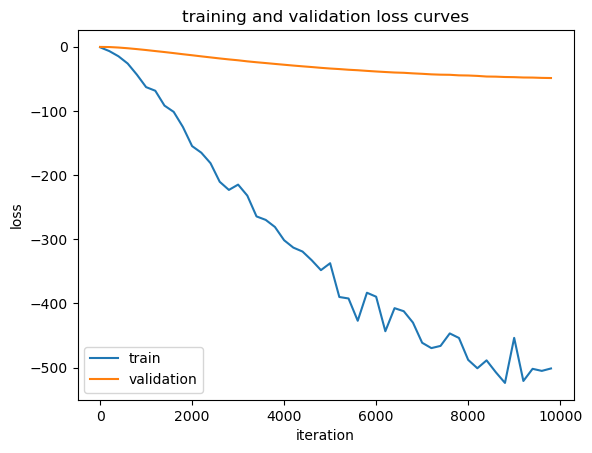

In [77]:
iters = [iter * ITERS_PER_EVAL for iter in range(len(train_losses))]
plt.plot(iters, train_losses, label='train')
plt.plot(iters, val_losses, label='validation')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('training and validation loss curves')
plt.legend()
plt.show()

In [75]:
# save models
import os

ITERATIONS = 10000
BATCH_SIZE = 512
LR = 1e-3
ITERS_PER_EVAL = 200
ITERS_PER_LR_DECAY = 200
K = 20
LAMBDA = 1e-6

hyper_params = {
    "iterations": ITERATIONS,
    "lr": LR,
    "batch_size": BATCH_SIZE
}

custom_param = ""

model_dir = "./models" + "/light_gcn/" + "model" + "_layers" \
      "_batch_size" + str(hyper_params["batch_size"]) + \
      "_epochs" + str(hyper_params["iterations"]) + custom_param + "/"

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

torch.save(hyper_params, model_dir + "hyper_params.pt")
torch.save(model.state_dict(), model_dir + "model.pt")



In [78]:
# evaluate on test set
model.eval()
test_edge_index = test_edge_index.to(device)
test_sparse_edge_index = test_sparse_edge_index.to(device)

test_loss, test_recall, test_precision, test_ndcg = evaluation(
            model, test_edge_index, test_sparse_edge_index, [train_edge_index, val_edge_index], K, LAMBDA)

print(f"[test_loss: {round(test_loss, 5)}, test_recall@{K}: {round(test_recall, 5)}, test_precision@{K}: {round(test_precision, 5)}, test_ndcg@{K}: {round(test_ndcg, 5)}")

[test_loss: -55.88976, test_recall@20: 0.07045, test_precision@20: 0.01599, test_ndcg@20: 0.04401
